In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from google.colab.patches import cv2_imshow
import random
import copy
import torch.utils.data as data
import math
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential  
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from tensorflow import keras
from keras import regularizers
import shutil

##Data preprocessing

In [ ]:
#get dataset from google colab and extract
archive = zipfile.ZipFile('/content/drive/My Drive/facial-keypoints-detection.zip')
archive.extractall()

idlookup_df = pd.read_csv("IdLookupTable.csv")
archive = zipfile.ZipFile('training.zip')
archive.extractall()
archive = zipfile.ZipFile('test.zip')
archive.extractall()
train2_df = pd.read_csv("training.csv")
test2_df = pd.read_csv("test.csv")

###Import Images

clean_train_data shape: (2140, 31)
unclean_train_data shape: (7049, 31)
Shape of train_images: (2140, 96, 96)
Shape of train_keypoints: (2140, 30)


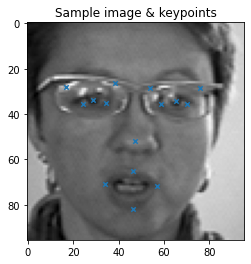

In [ ]:
clean_train_data = train2_df.dropna()
print("clean_train_data shape:", np.shape(clean_train_data))

unclean_train_data = train2_df.fillna(method = 'ffill')
print("unclean_train_data shape:", np.shape(unclean_train_data))

train_x = []
for _, sample in clean_train_data.iterrows():
        image = np.array(sample["Image"].split(' '), dtype=int)
        image = np.reshape(image, (96,96))
        train_x.append(image)

train_y = []
keypoint_data = clean_train_data.drop("Image", axis=1)
for _, sample_keypoints in keypoint_data.iterrows():
    train_y.append(sample_keypoints)
train_y = np.array(train_y, dtype="float")

full_train_x = []
for _, sample in unclean_train_data.iterrows():
        image = np.array(sample["Image"].split(' '), dtype=int)
        image = np.reshape(image, (96,96))
        full_train_x.append(image)

full_train_y = []
keypoint_data = unclean_train_data.drop("Image", axis=1)
for _, sample_keypoints in keypoint_data.iterrows():
    full_train_y.append(sample_keypoints)
full_train_y = np.array(full_train_y, dtype="float")

# print an example image with keypoints
def plot_sample(image, keypoint, axis, title):
    axis.imshow(image, cmap="gray")
    axis.scatter(keypoint[::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

print("Shape of train_images: {}".format(np.shape(train_x)))
print("Shape of train_keypoints: {}".format(np.shape(train_y)))

fig, axis = plt.subplots()
plot_sample(train_x[10], train_y[10], axis, "Sample image & keypoints")

random.seed(5)

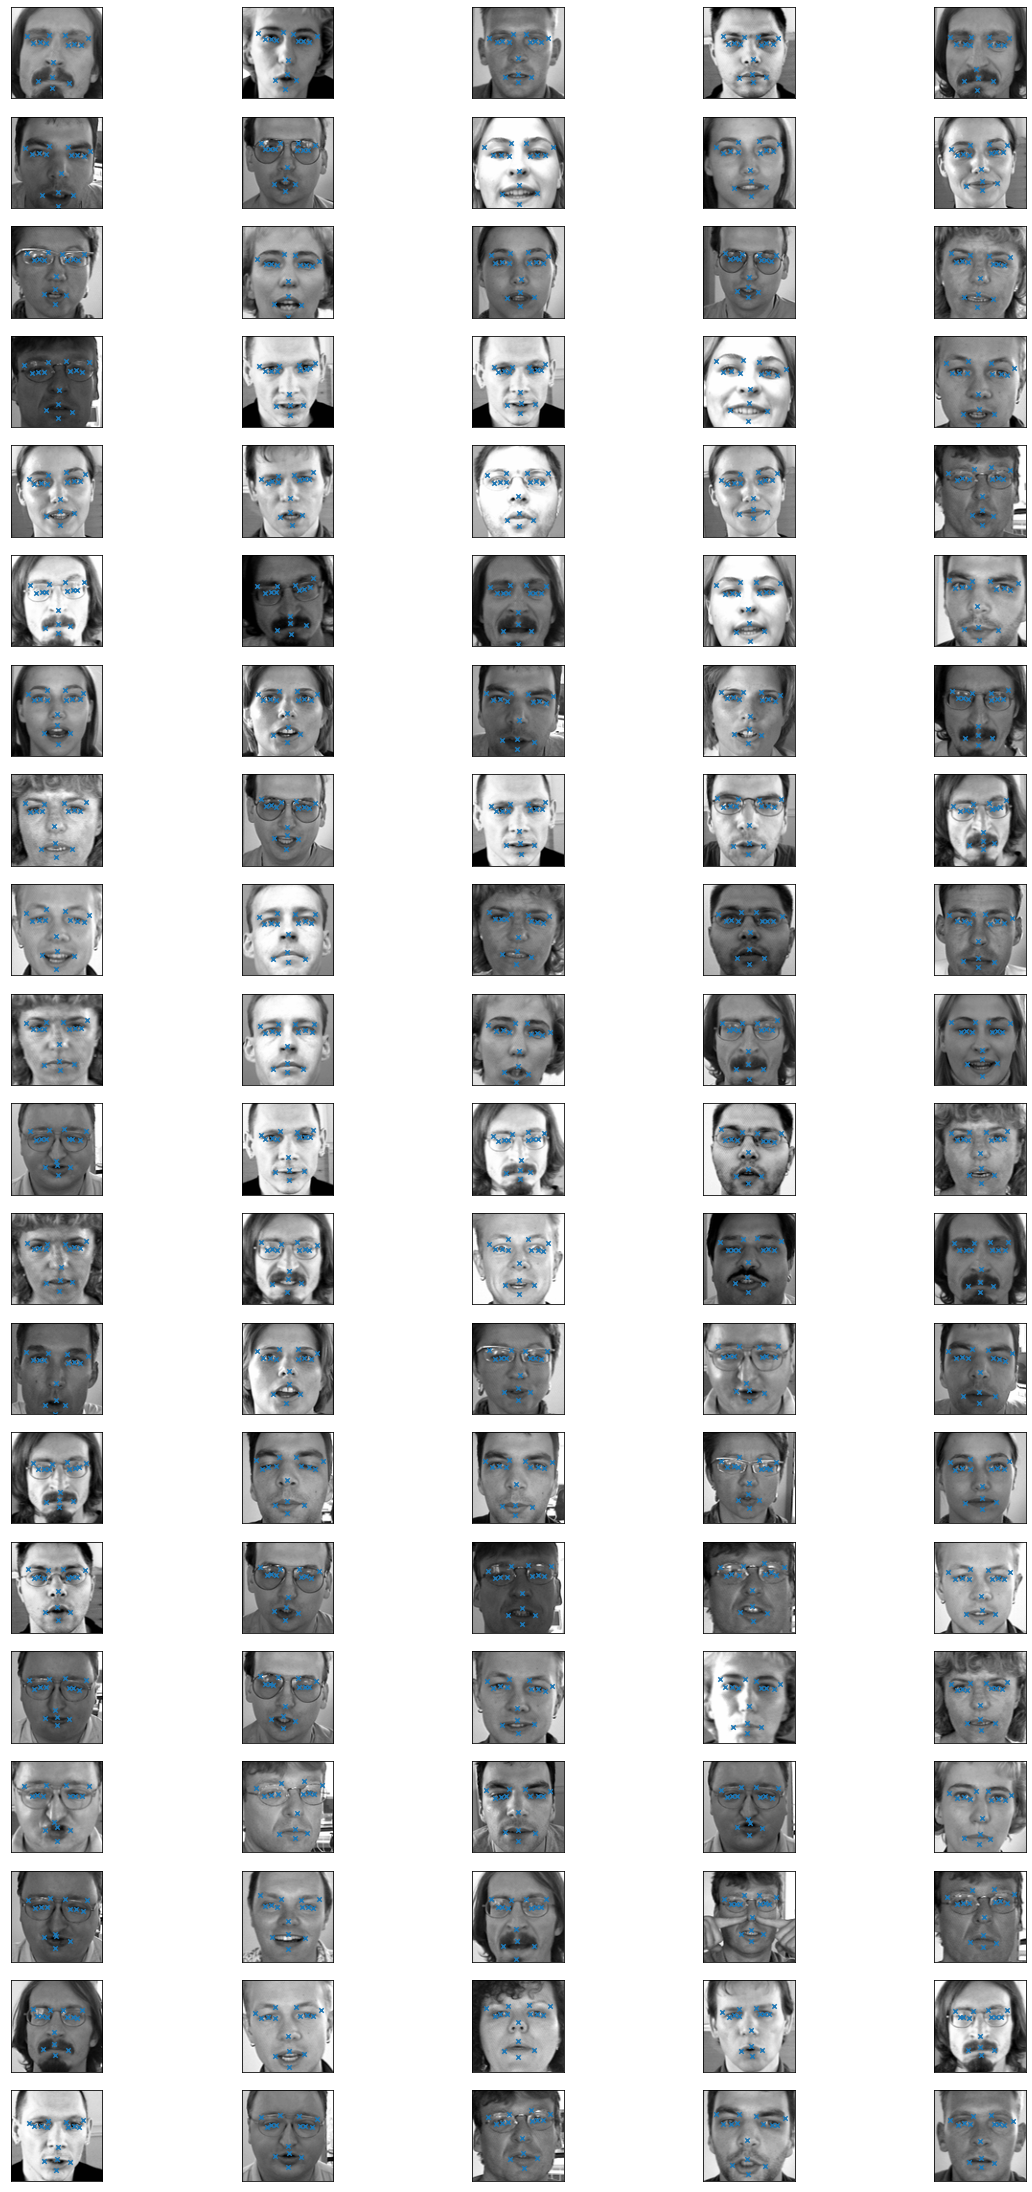

In [ ]:
fig = plt.figure(figsize=(20,40))
for i in range(100):
    axis = fig.add_subplot(20, 5, i+1, xticks=[], yticks=[])
    plot_sample(train_x[i], train_y[i], axis, "")
plt.show()

In [ ]:
# run for training the model on all the dataset
train_x = full_train_x
train_y = full_train_y

### Augment the training dataset

####Flip some images

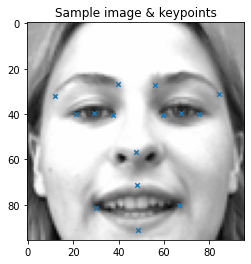

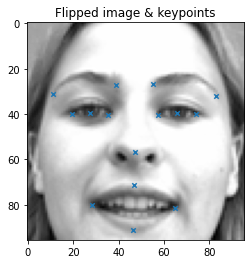

In [ ]:
# flip some of the images
flipped_x = []
flipped_y = []
ratio = 0.1
#random.seed(10)

num_flipped = int(ratio * len(train_x))

# randomly choose the images to be flipped
indices = sorted(random.sample(range(0, len(train_x)), num_flipped))
to_flip = [train_x[i] for i in range(len(train_x)) if i in indices]
labels = [train_y[i] for i in range(len(train_y)) if i in indices]

fig, axis = plt.subplots()
plot_sample(to_flip[0], labels[0], axis, "Sample image & keypoints")

# the zipfile library seems to interfere with the zip method
#for elem, y in zip(to_flip, labels):
for i in range(len(to_flip)):
  elem = to_flip[i]
  y = labels[i]
  elem = cv2.flip(elem, 1)
  y_f = []
  width = elem.shape[1]
  # at i is x which needs to be flipped; i+1 is y and stays same
  for i in range(0, len(y), 2):
    x_new = (width - 1) - y[i]
    y_f.append(x_new)
    y_f.append(y[i+1])
  flipped_x.append(elem)
  flipped_y.append(y_f)

fig, axis = plt.subplots()
plot_sample(flipped_x[0], flipped_y[0], axis, "Flipped image & keypoints")

####Add random noise to images

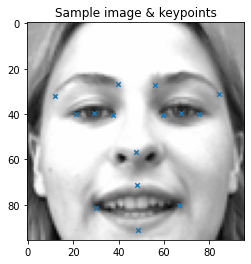

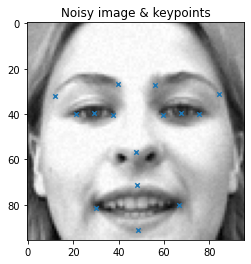

In [ ]:
# add noise to some of the images
noisy_x = []
ratio = 0.1

num_noisy = int(ratio * len(train_x))

# randomly choose the images
indices = sorted(random.sample(range(0, len(train_x)), num_noisy))
add_noise = [train_x[i] for i in range(len(train_x)) if i in indices]
noisy_y = [train_y[i] for i in range(len(train_y)) if i in indices]
max_noise = 10

fig, axis = plt.subplots()
plot_sample(add_noise[0], noisy_y[0], axis, "Sample image & keypoints")

for i in range(len(add_noise)):
  elem = add_noise[i]
  noise = np.random.randint(0, max_noise, (elem.shape[0], elem.shape[1]), dtype='uint8')
  elem += noise
  noisy_x.append(elem)

fig, axis = plt.subplots()
plot_sample(noisy_x[0], noisy_y[0], axis, "Noisy image & keypoints")

####Change the brightness

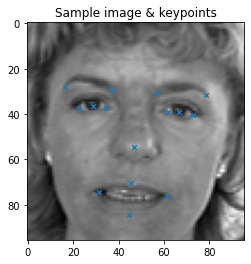

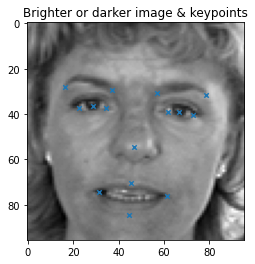

In [ ]:
#change the brightness of some of the images
def increase_brightness(img, value=50):
    for i, r in enumerate(img):
      for j, c in enumerate(r):
        if img[i, j] <= 255 - value:
          img[i, j] = img[i, j] + value
    return img

def decrease_brightness(img, value=50):
    for i, r in enumerate(img):
        for j, c in enumerate(r):
          if img[i, j] >= value:
            img[i, j] = img[i, j] - value
    return img


bright_x = []
ratio = 0.05

num_bright = int(ratio * len(train_x))

# randomly choose the images
indices = sorted(random.sample(range(0, len(train_x)), num_bright))
change_bright = [train_x[i] for i in range(len(train_x)) if i in indices]
bright_y = [train_y[i] for i in range(len(train_y)) if i in indices]
diff = 50

fig, axis = plt.subplots()
plot_sample(change_bright[0], bright_y[0], axis, "Sample image & keypoints")

for i in range(len(change_bright)):
  elem = change_bright[i]
  # change brightness of elem
  choice = random.random()
  
  if choice < 0.5:
    # increase the brightness
    elem_bright = increase_brightness(elem, value=diff)
  else: 
    # decrease the brightness
    elem_bright = decrease_brightness(elem, value=diff)
  bright_x.append(elem_bright)

fig, axis = plt.subplots()
plot_sample(bright_x[0], bright_y[0], axis, "Brighter or darker image & keypoints")

#### Equalize histograms

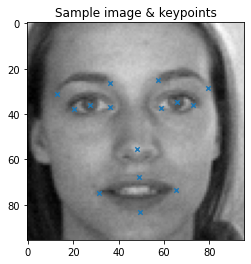

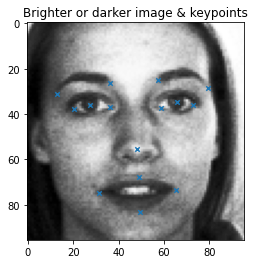

In [ ]:
eq_x = []
ratio = 0.05

num_eq = int(ratio * len(train_x))

# randomly choose the images
indices = sorted(random.sample(range(0, len(train_x)), num_eq))
equalize = [train_x[i] for i in range(len(train_x)) if i in indices]
eq_y = [train_y[i] for i in range(len(train_y)) if i in indices]

fig, axis = plt.subplots()
plot_sample(equalize[0], eq_y[0], axis, "Sample image & keypoints")

for i in range(len(equalize)):
  elem = equalize[i]
  elem_eq = cv2.equalizeHist(np.uint8(elem))
  eq_x.append(elem_eq)

fig, axis = plt.subplots()
plot_sample(eq_x[0], eq_y[0], axis, "Brighter or darker image & keypoints")

####Rotate some images

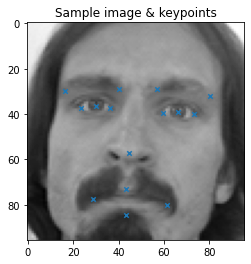

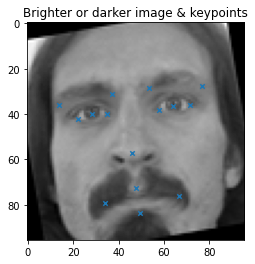

In [ ]:
# rotate some of the images
rot_x = []
rot_y = []
ratio = 0.1

num_rot = int(ratio * len(train_x))

# randomly choose the images
indices = sorted(random.sample(range(0, len(train_x)), num_rot))
rotate = [train_x[i] for i in range(len(train_x)) if i in indices]
labels = [train_y[i] for i in range(len(train_y)) if i in indices]
max_angle = 15

fig, axis = plt.subplots()
plot_sample(rotate[0], labels[0], axis, "Sample image & keypoints")

for i in range(len(rotate)):
  rotated_images = []
  rotated_keypoints_features = []
  angle = np.random.randint(5, max_angle)
  M = cv2.getRotationMatrix2D((96/2, 96/2), angle, 1.0)
  angle_rad = -angle * math.pi / 180
          
  image = rotate[i]
  rotated_image = cv2.warpAffine(np.uint8(image), M, (96, 96), flags=cv2.INTER_CUBIC)
  rot_x.append(rotated_image)

  keypoint = labels[i]
  rotated_keypoint = keypoint - 96/2.    
  for idx in range(0, len(rotated_keypoint),2):
      rotated_keypoint[idx] = rotated_keypoint[idx] * math.cos(angle_rad) - rotated_keypoint[idx+1] * math.sin(angle_rad)
      rotated_keypoint[idx+1] = rotated_keypoint[idx] * math.sin(angle_rad) + rotated_keypoint[idx+1] * math.cos(angle_rad)
      
  rotated_keypoint += 96/2
  rot_y.append(rotated_keypoint)


fig, axis = plt.subplots()
plot_sample(rot_x[0], rot_y[0], axis, "Brighter or darker image & keypoints")

In [ ]:
#train_x.extend(flipped_x)
#train_y = np.concatenate((train_y, np.array(flipped_y)), axis=0)
#train_x.extend(noisy_x)
#train_y = np.concatenate((train_y, np.array(noisy_y)), axis=0)
#train_x.extend(eq_x)
#train_y = np.concatenate((train_y, np.array(eq_y)), axis=0)
train_x.extend(rot_x)
train_y = np.concatenate((train_y, np.array(rot_y)), axis=0)
train_x.extend(bright_x)
train_y = np.concatenate((train_y, np.array(bright_y)), axis=0)
print(np.array(train_x).shape)
print(train_y.shape)
# might be useful also for us
train_x, train_y = shuffle(train_x, train_y, random_state=0)

(8105, 96, 96)
(8105, 30)


### Prepare data for CNN

####Dataset transforms
Possible transforms for the training and test datasets are:

  -> Denoising the images with a bilateral filter

  -> Normalize the image values to a range of [0, 1]

  -> Equalizing the histograms

  -> Adding noise to the images


In [ ]:
# Remove noise from images by using a bilateral filter
def denoise(images):
  out = []
  for image in images:
    bilat_blur = cv2.bilateralFilter(np.uint8(image), 3, 75, 75)
    out.append(bilat_blur)
  return out

# Normalize to range (0, 1)
def normalize(images):
  return np.array(images) / 255

# Equalize the histograms to create more contrast
def eq_hists(images):
  eqs = []
  for img in images:
    elem_eq = cv2.equalizeHist(np.uint8(img))
    eqs.append(elem_eq)
  return np.array(eqs)

# Add random noise btw. 0 and a max value to all pixels
def add_noise(images, max_noise=10):
  noisy = []
  for i in range(len(images)):
    elem = images[i]
    noise = np.random.randint(0, max_noise, (elem.shape[0], elem.shape[1]), dtype='uint8')
    noisy.append(images[i] + noise)
  return noisy

(2140, 96, 96)


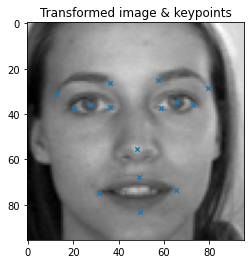

In [ ]:
# choose the preprocessing operations
#train_x = add_noise(train_x)
#train_x = eq_hists(train_x)
#train_x = denoise(train_x)
train_x = normalize(train_x)

# plot example
fig, axis = plt.subplots()
plot_sample(train_x[8], train_y[8], axis, "Transformed image & keypoints")
print(train_x.shape)

train_x = np.expand_dims(train_x, axis=3)

In [ ]:
print(train_x.shape)

(2461, 96, 96, 1)


##Train the CNN

###Define the model

In [ ]:
def mobile_net(l2_reg=0.5, alpha=0.1, lr=0.01, drop=0.1):
  mobile = Sequential()

  pretrained_model = tf.keras.applications.MobileNet(input_shape=(96, 96, 3), include_top=False, weights=None)
  pretrained_model.trainable = True

  number = len(train_x)
  mobile.add(layers.Convolution2D(3, (1, 1), padding='same', input_shape=(96,96,1), kernel_regularizer=regularizers.l2(l=l2_reg)))
  mobile.add(BatchNormalization())
  mobile.add(layers.LeakyReLU(alpha = alpha))
  mobile.add(pretrained_model)
  mobile.add(layers.GlobalAveragePooling2D())
  #mobile.add(layers.Dropout(drop))
  #mobile.add(Dense(512,activation='relu'))
  mobile.add(layers.Dropout(drop))
  mobile.add(layers.Dense(30))
  #mobile.summary()

  opt = keras.optimizers.Adam(learning_rate=lr)
  mobile.compile(optimizer=opt, loss="mean_squared_error", metrics=["accuracy"])
  #mobile.compile(optimizer=opt, loss="huber", metrics=["accuracy"])
  #mobile.summary()
  return mobile

In [ ]:
# model creation
def create_model(k_size=3, alpha=0.1, drop=0.1, act='relu', lr=0.01):
  model = Sequential()

  # ----------------------------------------
  model.add(Convolution2D(32, (k_size,k_size), padding='same', use_bias=False, input_shape=(96,96,1)))
  model.add(LeakyReLU(alpha = alpha))
  model.add(BatchNormalization())

  model.add(Convolution2D(32, (k_size,k_size), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = alpha))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))


  # ----------------------------------------
  model.add(Convolution2D(64, (k_size,k_size), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = alpha))
  model.add(BatchNormalization())

  model.add(Convolution2D(64, (k_size,k_size), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = alpha))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))


  # ----------------------------------------
  model.add(Convolution2D(96, (k_size,k_size), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = alpha))
  model.add(BatchNormalization())

  model.add(Convolution2D(96, (k_size,k_size), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = alpha))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))


  # ----------------------------------------
  model.add(Convolution2D(128, (k_size,k_size),padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())

  model.add(Convolution2D(128, (k_size,k_size),padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = alpha))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))


  # ----------------------------------------
  model.add(Convolution2D(256, (k_size,k_size),padding='same',use_bias=False))
  model.add(LeakyReLU(alpha = alpha))
  model.add(BatchNormalization())

  model.add(Convolution2D(256, (k_size,k_size),padding='same',use_bias=False))
  model.add(LeakyReLU(alpha = alpha))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))


  # ----------------------------------------
  model.add(Convolution2D(512, (k_size,k_size), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = alpha))
  model.add(BatchNormalization())

  model.add(Convolution2D(512, (k_size,k_size), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = alpha))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(512,activation=act))
  model.add(Dropout(drop))
  model.add(Dense(30))
  #model.summary()

  opt = keras.optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=opt, loss="mean_squared_error", metrics=["accuracy"])

  return model

###Prepare the test dataset

In [ ]:
clean_test_data = test2_df.dropna()
print("clean_train_data shape:", np.shape(clean_test_data))

unclean_test_data = test2_df.fillna(method = 'ffill')
print("unclean_train_data shape:", np.shape(unclean_test_data))

test_x = []
for _, sample in clean_test_data.iterrows():
        image = np.array(sample["Image"].split(' '), dtype=int)
        image = np.reshape(image, (96,96))
        test_x.append(image)

test_y = []
keypoint_data = clean_test_data.drop("Image", axis=1)
for _, sample_keypoints in keypoint_data.iterrows():
    test_y.append(sample_keypoints)
test_y = np.array(test_y, dtype="float")

clean_train_data shape: (1783, 2)
unclean_train_data shape: (1783, 2)


In [ ]:
# preprocess the test dataset
#test_x = denoise(test_x)
test_x = normalize(test_x)

###Train the CNN with Random Search

In [ ]:
# handimplemented Random search
random.seed(5)
tf.random.set_seed(5)

best_model = {}
max_acc = 0
for i in range(20):
  kernel_size = random.choice([3, 5, 7, 9])
  #act_fct = random.choice(['elu', 'relu'])
  act_fct = 'relu'
  alpha = random.uniform(0, 0.3)
  dropout = random.uniform(0, 0.6)
  reg = random.uniform(0, 0.7)
  lr = random.uniform(0, 0.1)

  print(f'Parameters: {kernel_size}, {act_fct}, {alpha}, {dropout}, {lr}, {batch_size}')
  #rand_model = create_model(k_size=kernel_size, alpha=alpha, drop=dropout, act='relu', lr=lr)
  rand_model = mobile_net(l2_reg=reg, alpha=alpha, lr=lr, drop=dropout)
  hist = rand_model.fit(train_x, train_y, epochs=100, batch_size=64, validation_split=0.05,shuffle=True)

  if np.average(hist.history['val_accuracy'][-5:]) > max_acc:
    max_acc = np.average(hist.history['val_accuracy'][-5:])
    best_model['model'] = rand_model
    best_model['val_acc'] = hist.history['val_accuracy']
    best_model['val_loss'] = hist.history['val_loss']
    best_model['acc'] = hist.history['accuracy']
    best_model['loss'] = hist.history['loss']
    best_model['alpha'] = alpha
    best_model['drop'] = dropout
    best_model['lr'] = lr
    best_model['batch_size'] = batch_size
    best_model['l2_reg'] = reg
  
  else:
    del rand_model


In [ ]:
# plot accuracy and loss
#  "Accuracy"
plt.plot(best_model['acc'])
plt.plot(best_model['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(best_model['loss'][5:])
plt.plot(best_model['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

for pair in best_model.items():
  if pair[0] != 'model':
    print(pair)

In [ ]:
# plot some examples of the network
test_x = np.expand_dims(test_x, axis=3)
pred_y = best_model['model'].predict(test_x[:5])
test_x = np.squeeze(test_x)

fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(test_x[i], pred_y[i], axis, "")
plt.show()

In [ ]:
best_model['model'].save('random_cnn_noise05')
model = keras.models.load_model('random_cnn_noise05')
# create a zip archive of the model to be able to download it to google drive
shutil.make_archive('cnn_200_epochs', 'zip', 'cnn_200_epochs')

###Train the optimized model

In [ ]:
#best_model = mobile_net(l2_reg=0.311, alpha=0.229, lr=0.013, drop=0.043)
#baseline model
best_model = mobile_net(l2_reg=0, alpha=0.1, lr=0.01, drop=0.1)
#best_model = create_model()
hist = best_model.fit(train_x, train_y, epochs=50, batch_size=128, validation_split=0.05,shuffle=True)

Epoch 1/50
16/16 [==============================] - 58s 303ms/step - loss: 1447.6001 - accuracy: 0.0606 - val_loss: 2023.9984 - val_accuracy: 0.4112
Epoch 2/50
16/16 [==============================] - 2s 135ms/step - loss: 42.6466 - accuracy: 0.6609 - val_loss: 1219.4622 - val_accuracy: 0.4299
Epoch 3/50
16/16 [==============================] - 2s 132ms/step - loss: 16.1180 - accuracy: 0.7174 - val_loss: 796.8174 - val_accuracy: 0.4299
Epoch 4/50
16/16 [==============================] - 2s 133ms/step - loss: 10.6884 - accuracy: 0.7072 - val_loss: 594.1476 - val_accuracy: 0.4299
Epoch 5/50
16/16 [==============================] - 2s 132ms/step - loss: 9.0349 - accuracy: 0.7263 - val_loss: 465.6013 - val_accuracy: 0.4299
Epoch 6/50
16/16 [==============================] - 2s 134ms/step - loss: 8.9336 - accuracy: 0.7295 - val_loss: 390.1611 - val_accuracy: 0.4299
Epoch 7/50
16/16 [==============================] - 2s 134ms/step - loss: 8.9613 - accuracy: 0.7186 - val_loss: 335.6985 - val_

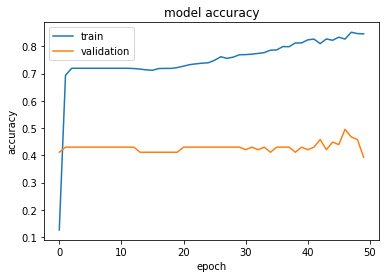

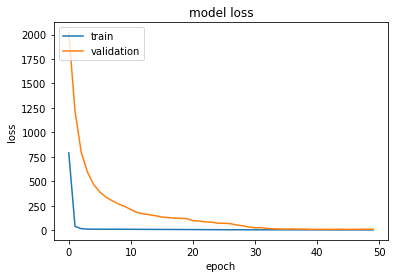

In [ ]:
# plot accuracy and loss
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

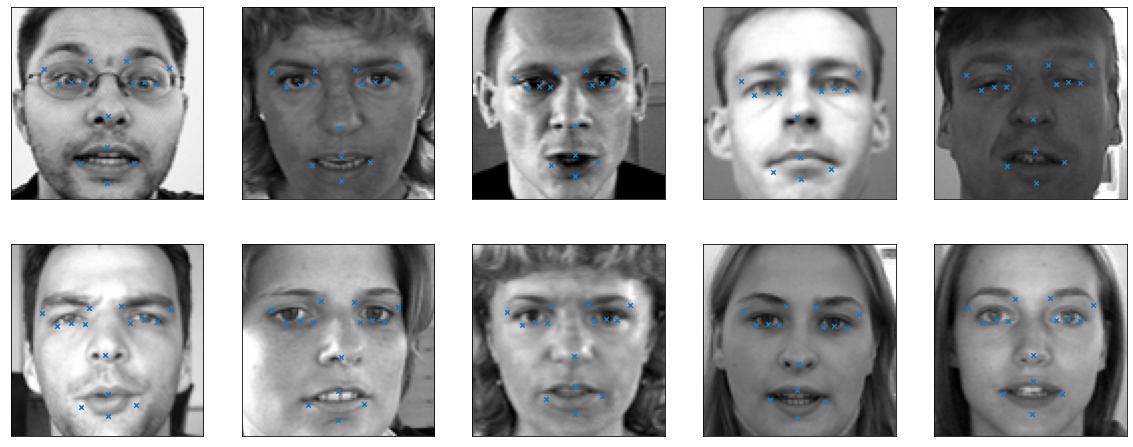

In [ ]:
test_x = np.expand_dims(test_x, axis=3)
pred_y = best_model.predict(test_x)
test_x = np.squeeze(test_x)

fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(test_x[i], pred_y[i], axis, "")
plt.show()


In [ ]:
best_model.save('full_data')
shutil.make_archive('full_data', 'zip', 'full_data')
shutil.unpack_archive('cnn_200_epochs.zip', extract_dir='cnn_200_epochs')
best_model = keras.models.load_model('cnn_200_epochs')

INFO:tensorflow:Assets written to: full_data/assets


INFO:tensorflow:Assets written to: full_data/assets


'/content/full_data.zip'

In [ ]:
# Continue training with unclean data
full_train_x = add_noise(full_train_x)
full_train_x = normalize(full_train_x)
full_train_x = np.expand_dims(full_train_x, axis=3)
hist = best_model.fit(full_train_x, full_train_y, epochs=100, batch_size=64, validation_split=0.05,shuffle=True)

Epoch 1/100
105/105 [==============================] - 6s 38ms/step - loss: 13.2303 - accuracy: 0.5538 - val_loss: 17.2221 - val_accuracy: 0.5722
Epoch 2/100
105/105 [==============================] - 3s 33ms/step - loss: 13.2293 - accuracy: 0.5506 - val_loss: 17.9360 - val_accuracy: 0.5694
Epoch 3/100
105/105 [==============================] - 4s 33ms/step - loss: 13.2445 - accuracy: 0.5473 - val_loss: 18.1908 - val_accuracy: 0.5411
Epoch 4/100
105/105 [==============================] - 4s 34ms/step - loss: 13.2167 - accuracy: 0.5499 - val_loss: 18.2284 - val_accuracy: 0.5524
Epoch 5/100
105/105 [==============================] - 3s 33ms/step - loss: 13.2172 - accuracy: 0.5505 - val_loss: 18.3602 - val_accuracy: 0.5354
Epoch 6/100
105/105 [==============================] - 4s 34ms/step - loss: 13.2214 - accuracy: 0.5535 - val_loss: 18.3609 - val_accuracy: 0.5467
Epoch 7/100
105/105 [==============================] - 4s 34ms/step - loss: 13.2301 - accuracy: 0.5488 - val_loss: 18.3710 -